# Model Evaluation
In this notebook, we delve into an analysis of the outcomes derived from testing the Ecosystem model. The primary objective of this model is to furnish a prioritized roster of potential customers for engagement in the marketing campaign, predicated on their likelihood of subscribing to a term deposit.

In [1]:
from time import time
import pickle as pkl

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.metrics import classification_report

In [4]:
timer_start = time()

We begin by importing the results of the Ecosystem model over the test set (see **ml_modeling.jpynb**).

In [5]:
with open(file="test_results.pkl",
          mode="rb") as test_results:
    results = pkl.load(file=test_results)

df = results["df"]
feature_importance = results["feature_importance"]
loss_eval = results["loss_eval"]

## Training Evaluation
Initially, we depict the timeline of loss evaluation across objective function calls for the Random Forests that form the core of the Ecosystem model.

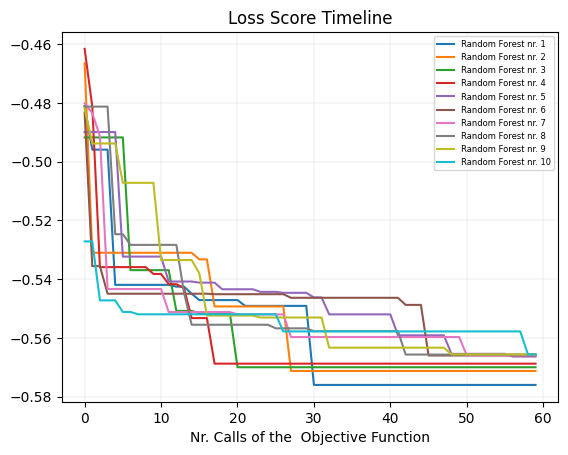

In [6]:
nr_calls = range(loss_eval.shape[1])
count = 0

for loss in loss_eval:
    count += 1
    y_axis = [min(loss[: call + 1]) for call in nr_calls]
    plt.plot(nr_calls, y_axis,
             label=f"Random Forest nr. {count}")

plt.title("Loss Score Timeline")
plt.xlabel("Nr. Calls of the  Objective Function")
plt.grid(c="grey",
         lw=.1)
plt.legend(prop={'size': 6})
plt.show()

## Performance of the Model
The core aim of this model is to provide a systematically ranked list of prospective customers who are most likely to engage with the marketing campaign by subscribing to a term deposit. To achieve this goal, we sort the test results based on their prediction probabilities.

In [7]:
df.sort_values(by="y_prob",
               ascending=False,
               inplace=True)

df.reset_index(inplace=True)

df.drop(labels=["index", 
                "y_prob"],
        axis=1,
        inplace=True)

Next, we construct a lift chart to illustrate how accurately the model performs across different percentiles of the ranked list of potential customers.

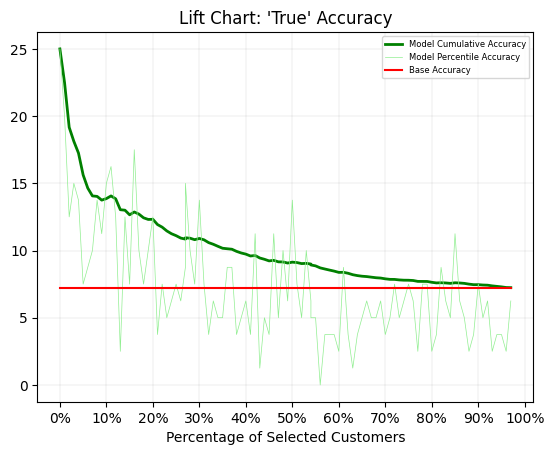

In [8]:
nr_entries = 100
percentiles = {round(percent, 2): int(percent * df.shape[0]) 
               for percent in [1 / nr_entries * (x + 1) 
                               for x in range(nr_entries)]}
x_axis = [f"{int(percent * 100)}%" 
          for percent in percentiles]

true_accuracy_cumulative, true_accuracy_percentile = [], []
previous_nr_customers = 0

for percent, nr_customers in percentiles.items():
    true_accuracy_cumulative.append(df.loc[: nr_customers].y_true.sum() 
                                    / nr_customers * 100)
    true_accuracy_percentile.append(df.loc[previous_nr_customers: nr_customers].y_true.sum() 
                                    / (nr_customers - previous_nr_customers) * 100)
    previous_nr_customers = nr_customers

plt.title("Lift Chart: 'True' Accuracy")
plt.xlabel("Percentage of Selected Customers")
plt.xticks(ticks=[int(percent * 100) 
                  for percent in [.1 * x 
                                  for x in range(11)]],
           labels=[f"{int(percent * 100)}%" 
                   for percent in [.1 * x 
                                   for x in range(11)]])

plt.plot(x_axis, true_accuracy_cumulative, 
         label="Model Cumulative Accuracy", 
         c="green", 
         lw=2)
plt.plot(x_axis, true_accuracy_percentile, 
         label="Model Percentile Accuracy", 
         c="lightgreen", 
         lw=.5)
plt.plot(x_axis, df.y_true.sum() / nr_customers * 100 * np.ones(nr_entries), 
         label="Base Accuracy", 
         c="red")

plt.grid(c="grey", lw=.1)
plt.legend(prop={'size': 6})
plt.show()

Now, we'll develop a gain chart to showcase the effectiveness of the model across various percentiles of the prioritized list of potential customers.

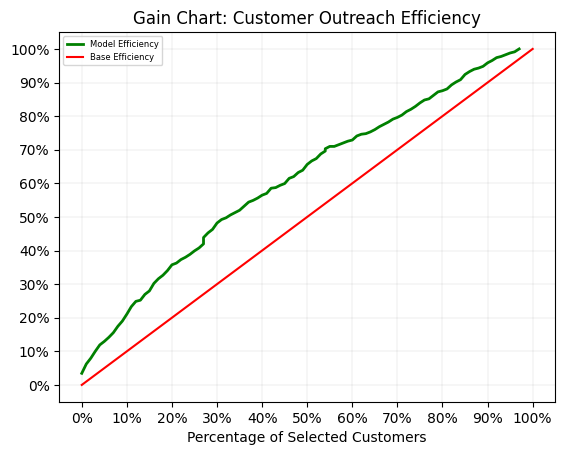

In [9]:
total_true = df.y_true.sum()

contacted_true_cumulative = []
for percent, nr_customers in percentiles.items():
    contacted_true_cumulative.append(df.loc[: nr_customers].y_true.sum() / total_true * 100)

plt.title("Gain Chart: Customer Outreach Efficiency")
plt.xlabel("Percentage of Selected Customers")
plt.xticks(ticks=[int(percent * 100) for percent in [.1 * x for x in range(11)]],
           labels=[f"{int(percent * 100)}%" for percent in [.1 * x for x in range(11)]])
plt.yticks(ticks=[int(percent * 100) for percent in [.1 * x for x in range(11)]],
           labels=[f"{int(percent * 100)}%" for percent in [.1 * x for x in range(11)]])
plt.plot(x_axis, contacted_true_cumulative, label="Model Efficiency", c="green", lw=2)
plt.plot([0, 100], [0, 100], label="Base Efficiency", c="red")
plt.grid(c="grey", lw=.1)
plt.legend(prop={'size': 6})
plt.show()

## Concluisions

1. The model demonstrates an accuracy of **14%** in identifying customers likely to subscribe to a term loan within the top 10% of the highest ranked potential customers, peaking at **25%** accuracy. It's important to note that this represents a significant improvement over the baseline accuracy of **7%**.
2. The efficiency of customer outreach facilitated by the model is **twice as effective** as the baseline within the top 10% of the highest ranked potential customers. Additionally, by reaching out to just **31%** of the total list of potential customers, **50%** of the total amount of possible subscribers to a term loan can be successfully contacted.

Finally, the model offers a feature importance analysis tool that not only enhances the depth of insights provided by the overall analysis, but also offers valuable opportunities for improving business strategies and decision-making processes.

In [10]:
feature_importance.rename(columns={"relevance": "Relevance %"},
                         inplace=True)

In [11]:
feature_importance.head().apply(func=lambda x: round(x * 100, 1))

,Relevance %
balance,45.5
age,24.8
education,4.8
housing,3.3
loan,3.1


In [12]:
print(f"Total running time of the script: {time() - timer_start: .2f}s")

Total running time of the script:  0.61s
